Julia notebook kernel

# CUDA

- https://docs.juliahub.com/CUDA/oWw5k/2.2.1/development/troubleshooting/
- https://github.com/JuliaGPU/KernelAbstractions.jl
  + https://juliagpu.github.io/KernelAbstractions.jl/dev/

# Wave equation 2d

$$
\begin{equation}
\frac{\partial^2 u}{\partial t^2}(x,y,t) - \left( \frac{\partial^2 u}{\partial x^2}(x,y,t) + \frac{\partial^2 u}{\partial y^2}(x,y,t) \right) = 0
\end{equation}
$$

Source: https://beltoforion.de/en/recreational_mathematics/2d-wave-equation.php

Also source: https://elar.urfu.ru/bitstream/10995/31219/1/978-5-7996-1342-6_2014.pdf
В. Г. Пименов, А. Б. Ложников ЧИСЛЕННЫЕ МЕТОДЫ В двух частях Часть 2 2014г. стр 87

TODO: absorbing boundary condition https://encyclopediaofmath.org/wiki/Absorbing_boundary_conditions

$$
\partial_t^2 u = \Delta u = \nabla^2 u
$$

The discrete version
$$
\begin{equation}
\partial_t^2 u^{(1)}_{i,j} = \frac{u^{(0)}_{i,j} - 2 u^{(1)}_{i,j} + u^{(2)}_{i,j}}{\tau^2}
\end{equation}
$$

The discrete version of the two-dimensional Laplace operator
$$
\begin{equation}		
		\quad \mathbf{D}^2_{i,j}=\begin{bmatrix}0 & 1 & 0\\1 & -4 & 1\\0 & 1 & 0\end{bmatrix}
\end{equation}
$$
$$
\begin{equation}
	\Delta u^{(1)}_{i,j} = \frac{u^{(1)}_{i-1,j}+u^{(1)}_{i+1,j}+u^{(1)}_{i,j-1}+u^{(1)}_{i,j+1} - 4 u^{(1)}_{i,j}}{h^2}
\end{equation}
$$

Solution is
$$
\begin{equation}
	u^{(k+1)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left( u^{(k)}_{i-1,j}+u^{(k)}_{i+1,j}+u^{(k)}_{i,j-1}+u^{(k)}_{i,j+1} - 4 u^{(k)}_{i,j} \right) + 2 u^{(k)}_{i,j} -  u^{(k-1)}_{i,j}
\end{equation}
$$
$$
\begin{equation}
	u^{(k+1)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left( \mathbf{D}^2_{i,j} u \right) + 2 u^{(k)}_{i,j} -  u^{(k-1)}_{i,j}
\end{equation}
$$

Начальнаые условия:
$$
\partial_t^2 u - \partial_x^2 u - \partial_y^2 u= 0
$$
$$
u(0,x,y) = \phi(x,y), \,\,\, \partial_t u |_{t=0} = \psi(x, y)
$$

In [1]:
const τ = 0.003
const h = 0.01
@assert (τ/h)^2 <= 1 # * условие сходимости

@inline fn(x) = x^2 < 1 ? -x^2 + 1 : 0
# * начальные условия
@inline ϕ(x, y) = fn(16 * (x^2 + y^2))
@inline ψ(x, y) = 0

# *
Mb = 2^20 # * one megabyte
allowed_gpu_mem = 1024Mb;
# *
T = 2.0
fps = 30
frames = 10fps

300

In [2]:
import Plots
Plots.gr()

function plot3d(data; zlims)
  (x, y, u_xy) = data
  Plots.surface(x, y, u_xy; size=(1000, 1000), zlims=zlims, clims=zlims)
end

function gif(arr, iter)
  anim = Plots.@animate for i in arr
    iter(i)
  end

  Plots.gif(anim, "tmp.gif", fps = fps)
end

gif (generic function with 1 method)

#### Use more accurate spatial derivatives

$O(h^4)$:
$$
\begin{equation}
		\nonumber
		\mathbf{D}^2_{(i,j)}=\frac{1}{12}\begin{bmatrix}0 & 0 & -1 & 0 & 0\\0 & 0 & 16 & 0 & 0\\-1 & 16 & -60 & 16 & -1\\0 & 0 & 16 & 0 & 0\\0 & 0 & -1 & 0 & 0\end{bmatrix}
\end{equation}
$$

$O(h^6)$:
$$
\begin{equation}		
		\nonumber
		\mathbf{D}^2_{(i,j)}=\frac{1}{180}\begin{bmatrix}0 & 0 & 0 & 2 & 0 & 0 & 0\\0 & 0 & 0 & -27 & 0 & 0 & 0\\0 & 0 & 0 & 270 & 0 & 0 & 0\\2 & -27 & 270 & -980 & 270 & -27 & 2\\ 0 & 0 & 0 & 270 & 0 & 0 & 0\\ 0 & 0 & 0 & -27 & 0 & 0 & 0\\0 & 0 & 0 & 2 & 0 & 0 & 0\end{bmatrix}
\end{equation}
$$

A version of the difference equation with a location derivative term of error order $O(h^4)$ looks like this:
$$
\begin{equation}
	u^{(0)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left(-u^{(1)}_{i,j-2}+16u^{(1)}_{i,j-1}-u^{(1)}_{i-2,j}+16u^{(1)}_{i-1,j}-60u^{(1)}_{i,j}+16u^{(1)}_{i+1,j}-u^{(1)}_{i+2,j}+16u^{(1)}_{i,j+1}-u^{(1)}_{i,j+2}  \right) + 2 u^{(1)}_{i,j} -  u^{(2)}_{i,j}
\end{equation}
$$

In [3]:
const x_start = -4
const x_end = 4
xx = x_start:h:x_end
yy = xx
@show const N = length(xx)

@inline x(i) = x_start + i * h
@inline y(j) = x(j)

# * нулевые заграничные условия
# @inline at(i, j, u, k) = i < 1 || i > N || j < 1 || j > N ? 0::Float32 : u[i, j, k]

@inline D2_h2(i, j; at) = at(i - 1, j) + at(i + 1, j) + at(i, j - 1) + at(i, j + 1) - 4 * at(i, j)

const N = length(xx) = 801


D2_h2 (generic function with 1 method)

In [4]:
# * cuda utils
import CUDA as cu
import CUDA: @cuda

cuthreads = let
  threadsmax = cu.attribute(cu.device(),cu.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)
  one_axis_threads = floor(Int, sqrt(threadsmax))
  (one_axis_threads, one_axis_threads)
end
@show cuthreads

cublocks = let
  one_axis_threads = cuthreads[1]
  one_axis_blocks = ceil(Int, N / one_axis_threads)
  (one_axis_blocks, one_axis_blocks)
end
@show cublocks

function cu_grid_idx_x()
  block_dim = cu.blockDim().x

  thread_idx = cu.threadIdx().x
  block_idx = cu.blockIdx().x
  grid_idx = (block_idx - 1) * block_dim + thread_idx;

  return grid_idx
end
function cu_grid_dim_x()
  grid_dim = cu.gridDim().x * cu.blockDim().x
  return grid_dim
end

function cu_grid_idx_y()
  block_dim = cu.blockDim().y

  thread_idx = cu.threadIdx().y
  block_idx = cu.blockIdx().y
  grid_idx = (block_idx - 1) * block_dim + thread_idx;

  return grid_idx
end
function cu_grid_dim_y()
  grid_dim = cu.gridDim().y * cu.blockDim().y
  return grid_dim
end

cuthreads = (32, 32)
cublocks = (26, 26)


cu_grid_dim_y (generic function with 1 method)

In [5]:
function gpu_set_initial_conditions!(u)
  idx_x = cu_grid_idx_x()
  dim_x = cu_grid_dim_x()
  idx_y = cu_grid_idx_y()
  dim_y = cu_grid_dim_y()

  for i in idx_x:dim_x:N, j in idx_y:dim_y:N
    @inbounds u[i, j, 1] = ϕ(x(i), y(j))
    @inbounds u[i, j, 2] = u[i, j, 1] + τ * ψ(x(i), y(j))
  end

  return nothing
end

function gpu_calc_next_layer!(u, k)
  idx_x = cu_grid_idx_x()
  dim_x = cu_grid_dim_x()
  idx_y = cu_grid_idx_y()
  dim_y = cu_grid_dim_y()

  at = (i, j) -> begin
    val::Float32 = 0
    # * нулевые заграничные условия
    if i < 1 || i > N || j < 1 || j > N
      return val
    end
    val = u[i, j, k]
    return val
  end
  # D2_h2 = (i, j) -> at(i - 1, j) + at(i + 1, j) + at(i, j - 1) + at(i, j + 1) - 4 * at(i, j)
  @inline d2(i, j) = D2_h2(i, j; at)

  σ = (τ / h)^2
  
  i = idx_x
  while i <= N
    j = idx_y
    while j <= N
      d2_ij = d2(i, j)
      @inbounds u[i, j, k+1] = -u[i, j, k-1] + 2 * u[i, j, k] + σ * d2_ij

      j = j + dim_y
    end

    i = i + dim_x
  end
  return nothing
end


gpu_calc_next_layer! (generic function with 1 method)

In [6]:
# const DATA_SLICE_LENGTH = 100

bytes_per_num = sizeof(Float32)
one_layer_volume = N * N * bytes_per_num
const DATA_SLICE_LENGTH = floor(Int, allowed_gpu_mem/one_layer_volume)
@show DATA_SLICE_LENGTH

mutable struct DataSlice
  fromIndex::Int64
  u::cu.CuArray{Float32,3,cu.Mem.DeviceBuffer}
end

function data_slice_create()
  u = cu.zeros(N, N, DATA_SLICE_LENGTH + 2) # * +2 начальных слоя для след. итерации
  DataSlice(1, u)
end

function data_slice_set_initial_conditions!(ds::DataSlice)
  ds.fromIndex = 1
  @cuda threads = cuthreads blocks = cublocks gpu_set_initial_conditions!(ds.u)
  cu.synchronize()
end

function data_slice_iterate!(ds::DataSlice)
  for k in 2:size(ds.u)[end] - 1
    @cuda threads = cuthreads blocks = cublocks gpu_calc_next_layer!(ds.u, k)
    cu.synchronize()
  end
end

function data_slice_prepare_next!(ds::DataSlice)
  ds.fromIndex = ds.fromIndex + DATA_SLICE_LENGTH
  cu.copyto!(ds.u, ds.u[:, :, end-1:end])
end

function data_slice_contains_index(ds::DataSlice, index::Int64) 
  index >= ds.fromIndex && index <= ds.fromIndex + DATA_SLICE_LENGTH - 1
end

function data_slice_get_layer_by_index(ds::DataSlice, index::Int64)
  if (!data_slice_contains_index(ds, index))
    return nothing
  end
  
  idx = mod(index, DATA_SLICE_LENGTH)
  ds.u[:,:,idx]
end
:ok

DATA_SLICE_LENGTH = 418


:ok

In [7]:
function solve!(ds::DataSlice; T)
  tt = 0:τ:T
  Nt = length(tt)

  data_slice_set_initial_conditions!(ds)
  data_slice_iterate!(ds)

  t_dim = floor(Int, Nt / frames)
  img = gif(1:t_dim:Nt, k -> begin
    u_xy = nothing
    while true
      u_xy = data_slice_get_layer_by_index(ds, k)
      if (u_xy != nothing)
        break
      end
      data_slice_prepare_next!(ds)
      data_slice_iterate!(ds)
    end
    plot3d((xx, yy, Array(u_xy)); zlims=(-1, 1))
  end)
  
  img
end

solve! (generic function with 1 method)

[ Info: Saved animation to d:\_docs\__math\__julia\src\samples\tmp.gif


Plots.AnimatedGif("d:\\_docs\\__math\\__julia\\src\\samples\\tmp.gif")
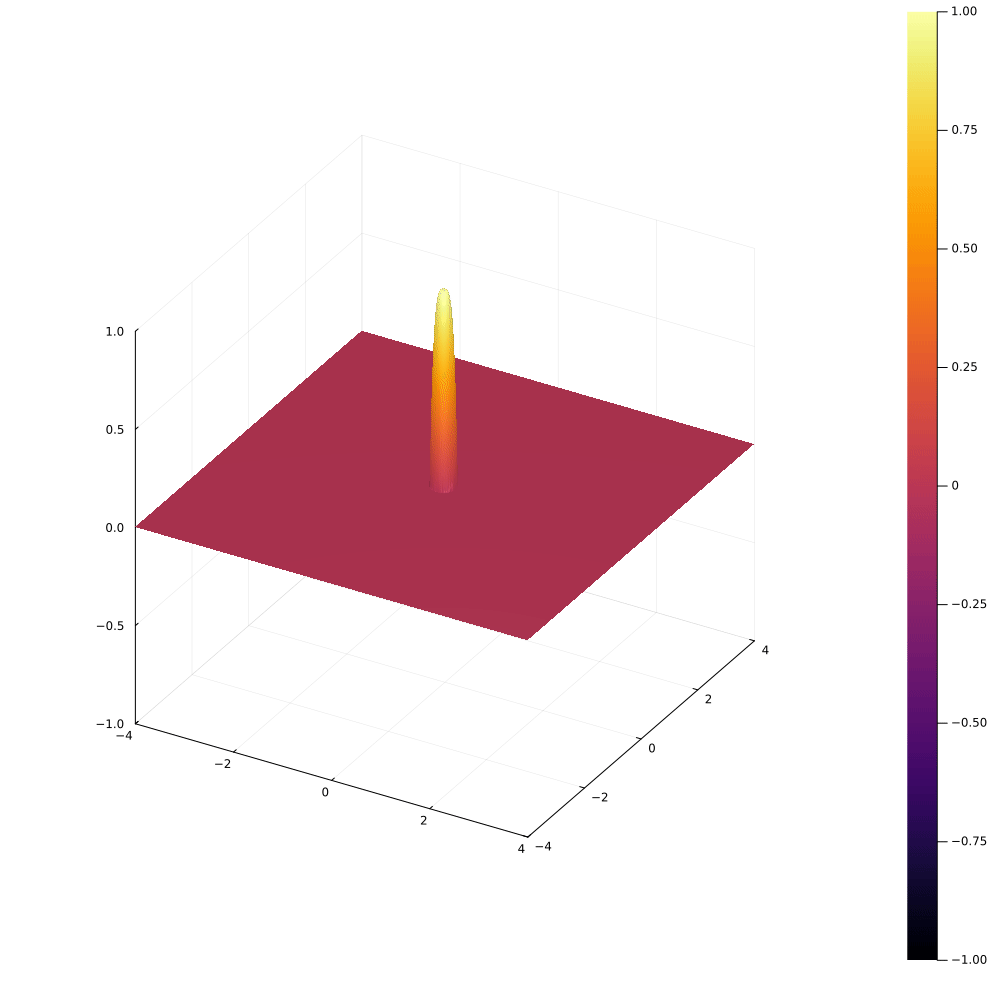

In [8]:
ds = data_slice_create()
solve!(ds; T=T)